In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("data.csv")

# Drop rows with missing critical values
df_clean = df.dropna(subset=['bid', 'ask', 'mid_iv', 'delta'])

# Calculate mid-price and spread
df_clean['mid'] = (df_clean['bid'] + df_clean['ask']) / 2
df_clean['spread'] = df_clean['ask'] - df_clean['bid']

# Filter out illiquid contracts
df_filtered = df_clean[(df_clean['spread'] < 1.0) & (df_clean['mid'] > 0.1)]

# Display top rows
print(df_filtered.head())

  option_type  strike expiration_date  yearstoexp    bid   ask  volume  \
0        call   150.0      2024-12-11    0.002712  98.35  98.8      12   
3        call   155.0      2024-12-11    0.002712  93.35  93.8       0   
5        call   160.0      2024-12-11    0.002712  88.35  88.8       0   
7        call   165.0      2024-12-11    0.002711  83.40  83.8       0   
9        call   170.0      2024-12-11    0.002711  78.40  78.8       0   

   open_interest    mid_iv  delta         gamma  theta     vega     mid  \
0              0  4.359806    1.0 -1.206183e-13    0.0  0.00002  98.575   
3              0  3.950886    1.0 -4.069190e-14    0.0  0.00002  93.575   
5              0  3.849435    1.0 -1.008739e-13    0.0  0.00002  88.575   
7              0  3.605216    1.0 -3.941784e-14    0.0  0.00002  83.600   
9              0  3.241280    1.0 -1.000877e-13    0.0  0.00002  78.600   

   spread  
0    0.45  
3    0.45  
5    0.45  
7    0.40  
9    0.40  


/var/folders/7g/0vk9nztx2wzc4mhqnxh6md440000gn/T/ipykernel_45751/3750206078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['mid'] = (df_clean['bid'] + df_clean['ask']) / 2
/var/folders/7g/0vk9nztx2wzc4mhqnxh6md440000gn/T/ipykernel_45751/3750206078.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['spread'] = df_clean['ask'] - df_clean['bid']


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Additional cleaning
df_filtered['expiration_date'] = pd.to_datetime(df_filtered['expiration_date'])
df_filtered['days_to_expiry'] = (df_filtered['expiration_date'] - pd.Timestamp.today()).dt.days

# Split calls and puts
calls = df_filtered[df_filtered['option_type'] == 'call'].copy()
puts = df_filtered[df_filtered['option_type'] == 'put'].copy()

/var/folders/7g/0vk9nztx2wzc4mhqnxh6md440000gn/T/ipykernel_45751/2838479379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['expiration_date'] = pd.to_datetime(df_filtered['expiration_date'])
/var/folders/7g/0vk9nztx2wzc4mhqnxh6md440000gn/T/ipykernel_45751/2838479379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['days_to_expiry'] = (df_filtered['expiration_date'] - pd.Timestamp.today()).dt.days


In [5]:
atm_calls = df_filtered[(df_filtered['option_type'] == 'call') & 
                        (df_filtered['delta'] > 0.45) & 
                        (df_filtered['delta'] < 0.55)]
atm_puts = df_filtered[(df_filtered['option_type'] == 'put') & 
                       (df_filtered['delta'] < -0.45) & 
                       (df_filtered['delta'] > -0.55)]

estimated_underlying = pd.concat([atm_calls, atm_puts])['strike'].mean()
print("Estimated Underlying Price:", estimated_underlying)

Estimated Underlying Price: 250.33898305084745


In [6]:
underlying_price = 250.34

def option_pnl(option_type, strike, premium, underlying_prices, is_long=True):
    if option_type == 'call':
        intrinsic = np.maximum(underlying_prices - strike, 0)
    else:  # put
        intrinsic = np.maximum(strike - underlying_prices, 0)
    
    pnl = intrinsic - premium if is_long else premium - intrinsic
    return pnl

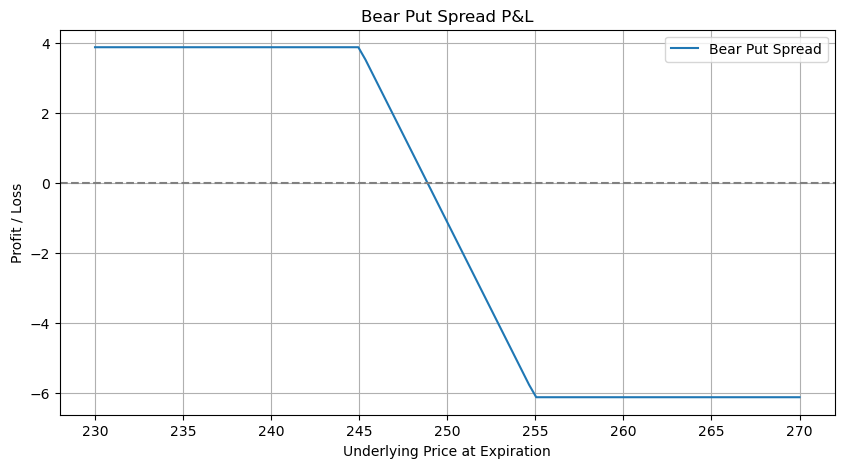

In [7]:
# Choose strikes around the money
long_put_strike = 255
short_put_strike = 245

# Get premiums
long_put = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == long_put_strike)].iloc[0]
short_put = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == short_put_strike)].iloc[0]

long_put_premium = long_put['mid']
short_put_premium = short_put['mid']

net_premium = long_put_premium - short_put_premium

price_range = np.linspace(230, 270, 100)
bear_put_pnl = (
    option_pnl('put', long_put_strike, long_put_premium, price_range, is_long=True) +
    option_pnl('put', short_put_strike, short_put_premium, price_range, is_long=False)
)

plt.figure(figsize=(10, 5))
plt.plot(price_range, bear_put_pnl, label='Bear Put Spread')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Bear Put Spread P&L")
plt.xlabel("Underlying Price at Expiration")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(True)
plt.show()

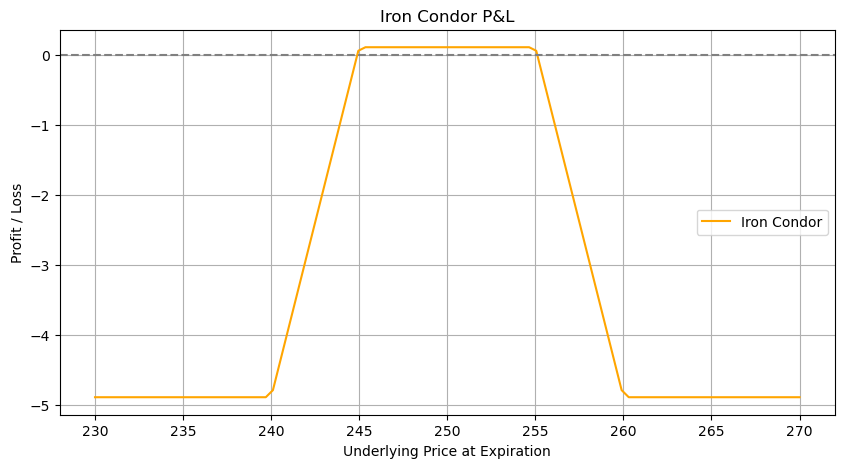

In [8]:
# Define strikes
lower_put = 240
short_put = 245
short_call = 255
upper_call = 260

# Fetch premiums
lp = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == lower_put)].iloc[0]['mid']
sp = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == short_put)].iloc[0]['mid']
sc = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == short_call)].iloc[0]['mid']
uc = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == upper_call)].iloc[0]['mid']

iron_condor_pnl = (
    option_pnl('put', lower_put, lp, price_range, is_long=True) +
    option_pnl('put', short_put, sp, price_range, is_long=False) +
    option_pnl('call', short_call, sc, price_range, is_long=False) +
    option_pnl('call', upper_call, uc, price_range, is_long=True)
)

plt.figure(figsize=(10, 5))
plt.plot(price_range, iron_condor_pnl, label='Iron Condor', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Iron Condor P&L")
plt.xlabel("Underlying Price at Expiration")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(True)
plt.show()

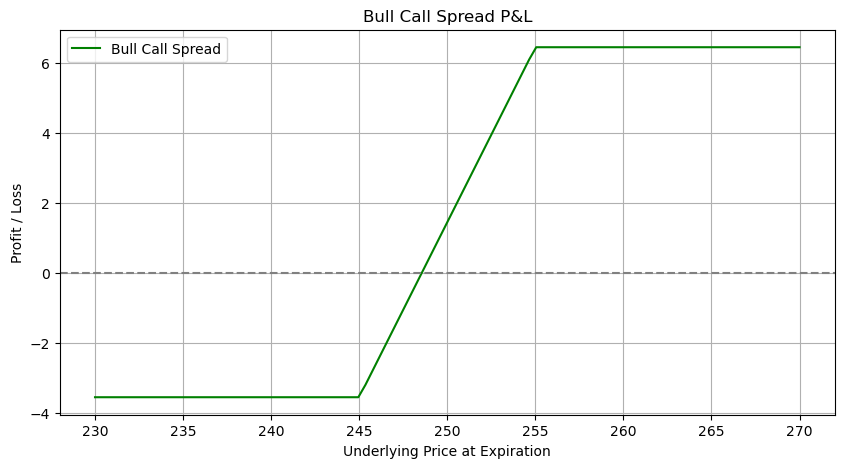

In [9]:
# Define strikes for Bull Call Spread
long_call_strike = 245
short_call_strike = 255

# Get option premiums from filtered DataFrame
long_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == long_call_strike)].iloc[0]
short_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == short_call_strike)].iloc[0]

long_call_premium = long_call['mid']
short_call_premium = short_call['mid']

# Net premium paid for the spread
net_premium_bull = long_call_premium - short_call_premium

# Define a range of underlying prices
price_range = np.linspace(230, 270, 100)

# Calculate P&L for each leg
bull_call_pnl = (
    option_pnl('call', long_call_strike, long_call_premium, price_range, is_long=True) +
    option_pnl('call', short_call_strike, short_call_premium, price_range, is_long=False)
)

# Plot the P&L chart
plt.figure(figsize=(10, 5))
plt.plot(price_range, bull_call_pnl, label='Bull Call Spread', color='green')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Bull Call Spread P&L")
plt.xlabel("Underlying Price at Expiration")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Extract full rows
long_put = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == long_put_strike)].iloc[0]
short_put = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == short_put_strike)].iloc[0]

# Only extract premiums to use elsewhere, but don't overwrite the full rows
long_put_premium = float(long_put['mid'])
short_put_premium = float(short_put['mid'])

long_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == long_call_strike)].iloc[0]
short_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == short_call_strike)].iloc[0]

# --- Strategy Analysis Functions ---
def analyze_spread(name, long_option, short_option, option_type):
    long_strike = float(long_option['strike'])
    long_premium = float(long_option['mid'])
    short_strike = float(short_option['strike'])
    short_premium = float(short_option['mid'])

    if option_type == 'put':
        max_profit = (long_strike - short_strike) - (long_premium - short_premium)
        max_loss = long_premium - short_premium
        breakeven = long_strike - max_loss
    elif option_type == 'call':
        max_profit = (short_strike - long_strike) - (long_premium - short_premium)
        max_loss = long_premium - short_premium
        breakeven = long_strike + max_loss
    else:
        return

    print(f"\n{name} Analysis:")
    print(f"  Max Profit: ${max_profit:.2f}")
    print(f"  Max Loss: ${max_loss:.2f}")
    print(f"  Breakeven Price: ${breakeven:.2f}")
    print(f"  Delta Sensitivity: {(float(long_option['delta']) - float(short_option['delta'])):.4f}")
    print(f"  Vega Sensitivity: {(float(long_option['vega']) - float(short_option['vega'])):.4f}")
    
# Bear Put Spread
analyze_spread(
    "Bear Put Spread",
    long_option=long_put,
    short_option=short_put,
    option_type='put'
)

# Bull Call Spread
analyze_spread(
    "Bull Call Spread",
    long_option=long_call,
    short_option=short_call,
    option_type='call'
)

# --- Iron Condor Analysis ---
# Ensure all components are numeric
sp = float(sp)
lp = float(lp)
sc = float(sc)
uc = float(uc)
lower_put = float(lower_put)
short_call_strike = float(short_call['strike'])  # using from earlier defined short_call
iron_condor_credit = sp - lp + sc - uc
max_loss_ic = (short_call_strike - lower_put) - iron_condor_credit

print("\nIron Condor Analysis:")
print(f"  Max Profit (Total Credit): ${iron_condor_credit:.2f}")
print(f"  Max Loss: ${max_loss_ic:.2f}")
print(f"  Breakeven Prices: ${lower_put + (lp - sp):.2f} and ${short_call_strike + (sc - uc):.2f}")
print(f"  Delta Sensitivity (Net): {(
    float(df_filtered[(df_filtered['strike'] == lower_put) & (df_filtered['option_type'] == 'put')].iloc[0]['delta']) +
    float(df_filtered[(df_filtered['strike'] == upper_call) & (df_filtered['option_type'] == 'call')].iloc[0]['delta']) -
    float(df_filtered[(df_filtered['strike'] == short_put_strike) & (df_filtered['option_type'] == 'put')].iloc[0]['delta']) -
    float(df_filtered[(df_filtered['strike'] == short_call_strike) & (df_filtered['option_type'] == 'call')].iloc[0]['delta'])
):.4f}")
print(f"  Vega Sensitivity (Net): {(
    float(df_filtered[(df_filtered['strike'] == lower_put) & (df_filtered['option_type'] == 'put')].iloc[0]['vega']) +
    float(df_filtered[(df_filtered['strike'] == upper_call) & (df_filtered['option_type'] == 'call')].iloc[0]['vega']) -
    float(df_filtered[(df_filtered['strike'] == short_put_strike) & (df_filtered['option_type'] == 'put')].iloc[0]['vega']) -
    float(df_filtered[(df_filtered['strike'] == short_call_strike) & (df_filtered['option_type'] == 'call')].iloc[0]['vega'])
):.4f}")


Bear Put Spread Analysis:
  Max Profit: $3.87
  Max Loss: $6.13
  Breakeven Price: $248.87
  Delta Sensitivity: -0.8373
  Vega Sensitivity: -0.0527

Bull Call Spread Analysis:
  Max Profit: $6.45
  Max Loss: $3.55
  Breakeven Price: $248.56
  Delta Sensitivity: 0.8593
  Vega Sensitivity: -0.0088

Iron Condor Analysis:
  Max Profit (Total Credit): $0.11
  Max Loss: $14.89
  Breakeven Prices: $239.88 and $254.99
  Delta Sensitivity (Net): 0.0684
  Vega Sensitivity (Net): 0.0058


In [16]:
# --- Additional Strategy Analysis Functions ---

def analyze_straddle(strike, call_row, put_row):
    call_mid = float(call_row['mid'])
    put_mid = float(put_row['mid'])
    total_cost = call_mid + put_mid
    breakeven_upper = strike + total_cost
    breakeven_lower = strike - total_cost
    max_loss = total_cost

    print("\nStraddle Analysis:")
    print(f"  Max Profit: Unlimited")
    print(f"  Max Loss: ${max_loss:.2f}")
    print(f"  Breakeven Prices: ${breakeven_lower:.2f} and ${breakeven_upper:.2f}")
    print(f"  Delta Sensitivity (Net): {(float(call_row['delta']) + float(put_row['delta'])):.4f}")
    print(f"  Vega Sensitivity (Net): {(float(call_row['vega']) + float(put_row['vega'])):.4f}")

def analyze_strangle(lower_strike, upper_strike, put_row, call_row):
    call_mid = float(call_row['mid'])
    put_mid = float(put_row['mid'])
    total_cost = call_mid + put_mid
    breakeven_upper = upper_strike + total_cost
    breakeven_lower = lower_strike - total_cost
    max_loss = total_cost

    print("\nStrangle Analysis:")
    print(f"  Max Profit: Unlimited")
    print(f"  Max Loss: ${max_loss:.2f}")
    print(f"  Breakeven Prices: ${breakeven_lower:.2f} and ${breakeven_upper:.2f}")
    print(f"  Delta Sensitivity (Net): {(float(call_row['delta']) + float(put_row['delta'])):.4f}")
    print(f"  Vega Sensitivity (Net): {(float(call_row['vega']) + float(put_row['vega'])):.4f}")

def analyze_butterfly_spread(lower, middle, upper, option_type):
    buy1 = df_filtered[(df_filtered['strike'] == lower) & (df_filtered['option_type'] == option_type)].iloc[0]
    sell2 = df_filtered[(df_filtered['strike'] == middle) & (df_filtered['option_type'] == option_type)].iloc[0]
    buy3 = df_filtered[(df_filtered['strike'] == upper) & (df_filtered['option_type'] == option_type)].iloc[0]

    cost = float(buy1['mid']) + float(buy3['mid']) - 2 * float(sell2['mid'])
    width = upper - middle
    max_profit = width - cost
    max_loss = cost

    print(f"\n{option_type.capitalize()} Butterfly Spread:")
    print(f"  Max Profit: ${max_profit:.2f}")
    print(f"  Max Loss: ${max_loss:.2f}")
    print(f"  Breakeven Prices: ${lower + cost:.2f} and ${upper - cost:.2f}")
    print(f"  Delta Sensitivity (Net): {(float(buy1['delta']) + float(buy3['delta']) - 2 * float(sell2['delta'])):.4f}")
    print(f"  Vega Sensitivity (Net): {(float(buy1['vega']) + float(buy3['vega']) - 2 * float(sell2['vega'])):.4f}")

In [17]:
# Straddle at ATM strike
atm_strike = float(short_call['strike'])
atm_call = short_call
atm_put = short_put
analyze_straddle(atm_strike, atm_call, atm_put)

# Strangle (slightly OTM strikes)
strangle_lower = float(long_put['strike'])
strangle_upper = float(long_call['strike'])
strangle_put = long_put
strangle_call = long_call
analyze_strangle(strangle_lower, strangle_upper, strangle_put, strangle_call)

# Butterfly (example with puts)
butterfly_put_lower = float(long_put['strike']) - 5
butterfly_put_middle = float(long_put['strike'])
butterfly_put_upper = float(long_put['strike']) + 5
analyze_butterfly_spread(butterfly_put_lower, butterfly_put_middle, butterfly_put_upper, option_type='put')

# Butterfly (example with calls)
butterfly_call_lower = float(long_call['strike']) - 5
butterfly_call_middle = float(long_call['strike'])
butterfly_call_upper = float(long_call['strike']) + 5
analyze_butterfly_spread(butterfly_call_lower, butterfly_call_middle, butterfly_call_upper, option_type='call')


Straddle Analysis:
  Max Profit: Unlimited
  Max Loss: $0.44
  Breakeven Prices: $254.56 and $255.44
  Delta Sensitivity (Net): -0.0956
  Vega Sensitivity (Net): 0.0841

Strangle Analysis:
  Max Profit: Unlimited
  Max Loss: $10.12
  Breakeven Prices: $244.88 and $255.12
  Delta Sensitivity (Net): -0.0736
  Vega Sensitivity (Net): 0.0225

Put Butterfly Spread:
  Max Profit: $4.68
  Max Loss: $0.32
  Breakeven Prices: $250.32 and $259.68
  Delta Sensitivity (Net): 0.2535
  Vega Sensitivity (Net): 0.0387

Call Butterfly Spread:
  Max Profit: $3.37
  Max Loss: $1.63
  Breakeven Prices: $241.63 and $248.37
  Delta Sensitivity (Net): -0.5817
  Vega Sensitivity (Net): 0.0027


In [30]:
# --- Calendar Spread (Diagonal) ---
short_call_strike = 250

near_call_df = df_filtered[
    (df_filtered['option_type'] == 'call') &
    (df_filtered['strike'] == short_call_strike) &
    (df_filtered['days_to_expiry'] < 30)
]

far_call_df = df_filtered[
    (df_filtered['option_type'] == 'call') &
    (df_filtered['strike'] == short_call_strike) &
    (df_filtered['days_to_expiry'] > 30)
]

if not near_call_df.empty and not far_call_df.empty:
    near_call = near_call_df.iloc[0]
    far_call = far_call_df.iloc[0]

    print("\nCalendar Spread (Diagonal) Analysis:")
    print(f"  Max Loss: ${(float(far_call['mid']) - float(near_call['mid'])):.2f}")
    print(f"  Breakeven: Approx {short_call_strike:.2f} at expiry of near leg")
    print(f"  Delta Sensitivity (Near - Far): {(float(near_call['delta']) - float(far_call['delta'])):.4f}")
    print(f"  Vega Sensitivity (Far - Near): {(float(far_call['vega']) - float(near_call['vega'])):.4f}")
else:
    print("\nCalendar Spread (Diagonal) Analysis:")
    print("  ⚠️ Option data not available for both near and far expiries at strike:", short_call_strike)
    
# --- Iron Butterfly ---
center_strike = short_call_strike
short_put_ib = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == center_strike)].iloc[0]
short_call_ib = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == center_strike)].iloc[0]
long_put_ib = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == lower_put)].iloc[0]
long_call_ib = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == upper_call)].iloc[0]

total_credit_ib = float(short_put_ib['mid']) + float(short_call_ib['mid']) - float(long_put_ib['mid']) - float(long_call_ib['mid'])
max_loss_ib = (center_strike - lower_put) - total_credit_ib

print("\nIron Butterfly Analysis:")
print(f"  Max Profit (Total Credit): ${total_credit_ib:.2f}")
print(f"  Max Loss: ${max_loss_ib:.2f}")
print(f"  Breakeven Prices: ${center_strike - total_credit_ib:.2f} and ${center_strike + total_credit_ib:.2f}")

# --- Covered Call (Optional) ---
# Assuming you hold 100 shares at underlying_price
covered_call_credit = float(short_call['mid'])
max_profit_cc = (short_call_strike - underlying_price) + covered_call_credit

print("\nCovered Call Analysis:")
print(f"  Max Profit: ${max_profit_cc:.2f}")
print("  Max Loss: Depends on how much stock can fall (partial hedge)")
print(f"  Breakeven Price: ${underlying_price - covered_call_credit:.2f}")


Calendar Spread (Diagonal) Analysis:
  ⚠️ Option data not available for both near and far expiries at strike: 250

Iron Butterfly Analysis:
  Max Profit (Total Credit): $1.83
  Max Loss: $8.17
  Breakeven Prices: $248.17 and $251.83

Covered Call Analysis:
  Max Profit: $-0.22
  Max Loss: Depends on how much stock can fall (partial hedge)
  Breakeven Price: $250.22


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_strategy_payoff(name, underlying_price, payoff_func, price_range=15):
    prices = np.linspace(underlying_price - price_range, underlying_price + price_range, 300)
    payoffs = [payoff_func(p) for p in prices]

    plt.figure(figsize=(10, 6))
    plt.plot(prices, payoffs, label=f'{name} Payoff', color='blue')
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(underlying_price, color='red', linestyle='--', label='Current Price')
    plt.title(f'{name} Strategy Payoff')
    plt.xlabel('Underlying Price at Expiration')
    plt.ylabel('Profit / Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

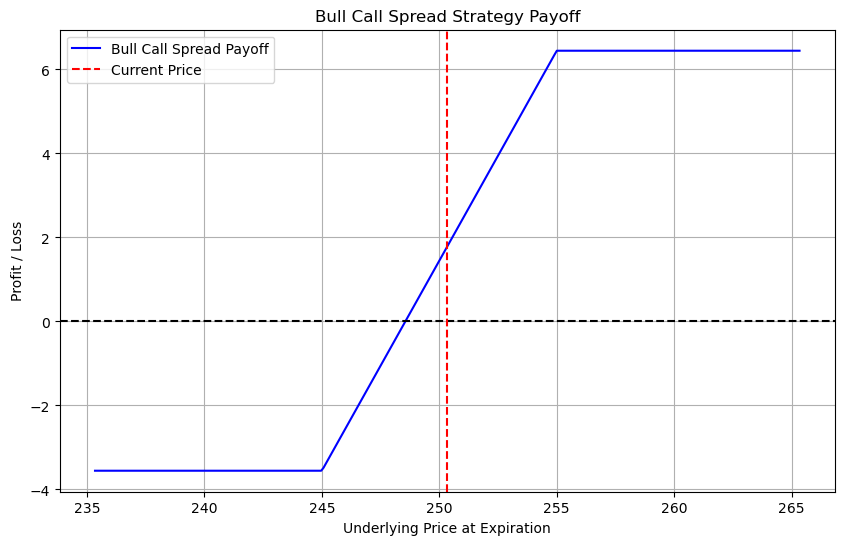

In [27]:
def bull_call_spread_payoff(S):
    long_call_strike = 245
    short_call_strike = 255

    # Get option premiums from filtered DataFrame
    long_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == long_call_strike)].iloc[0]
    short_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == short_call_strike)].iloc[0]

    long_call_premium = long_call['mid']
    short_call_premium = short_call['mid']
    
    return max(S - long_call_strike, 0) - long_call_premium - (max(S - short_call_strike, 0) - short_call_premium)

plot_strategy_payoff("Bull Call Spread", 250.34, bull_call_spread_payoff)

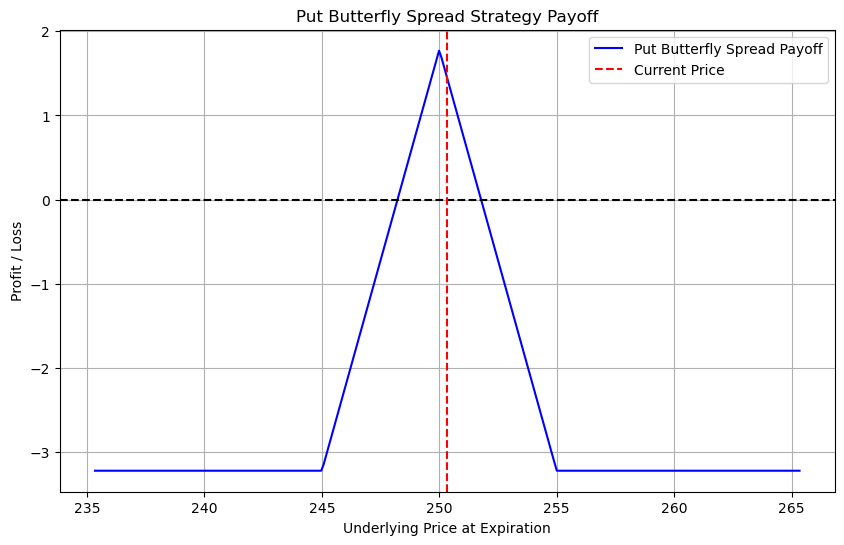

In [28]:
def put_butterfly_payoff(S):
    K1, K2, K3 = 245, 250, 255  # strikes for long put, 2x short put, long put

    # Get option premiums
    put1 = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == K1)].iloc[0]['mid']
    put2 = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == K2)].iloc[0]['mid']
    put3 = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == K3)].iloc[0]['mid']

    # Net premium paid (long + long - 2x short)
    total_premium = put1 + put3 - 2 * put2

    return max(K1 - S, 0) - 2 * max(K2 - S, 0) + max(K3 - S, 0) - total_premium

plot_strategy_payoff("Put Butterfly Spread", 250.34, put_butterfly_payoff)

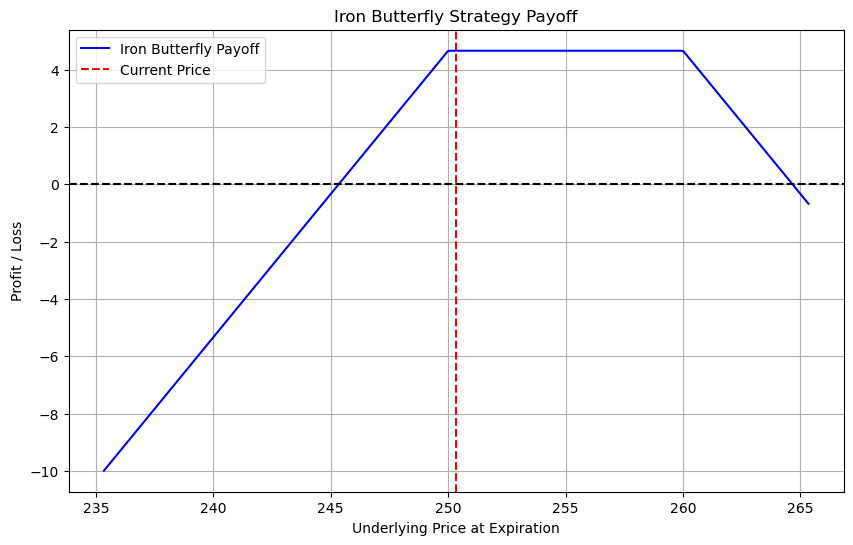

In [29]:
def iron_butterfly_payoff(S):
    K_put = 250
    K_call = 260
    K_short = 255  # both short call and short put

    # Get premiums
    long_put = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == K_put)].iloc[0]['mid']
    short_put = df_filtered[(df_filtered['option_type'] == 'put') & (df_filtered['strike'] == K_short)].iloc[0]['mid']
    short_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == K_short)].iloc[0]['mid']
    long_call = df_filtered[(df_filtered['option_type'] == 'call') & (df_filtered['strike'] == K_call)].iloc[0]['mid']

    # Net credit
    credit_received = short_put + short_call - long_put - long_call

    if S < K_put:
        return credit_received - (K_put - S)
    elif K_put <= S < K_short:
        return credit_received
    elif K_short <= S <= K_call:
        return credit_received
    elif S > K_call:
        return credit_received - (S - K_call)
    
plot_strategy_payoff("Iron Butterfly", 250.34, iron_butterfly_payoff)

In [34]:
# Group by strike for simplicity (this can be enhanced to match actual strategy legs)
grouped_calls = calls.groupby('strike').agg({'mid': 'mean', 'vega': 'mean'}).reset_index()
grouped_puts = puts.groupby('strike').agg({'mid': 'mean', 'vega': 'mean'}).reset_index()

# ----------------------
# Strategy Vega Analysis
# ----------------------

# 1. Bull Call Spread: Buy lower strike call, sell higher strike call
def bull_call_spread_vega(lower_strike, higher_strike):
    long_vega = grouped_calls[grouped_calls['strike'] == lower_strike]['vega'].values
    short_vega = grouped_calls[grouped_calls['strike'] == higher_strike]['vega'].values
    if long_vega.size > 0 and short_vega.size > 0:
        net_vega = long_vega[0] - short_vega[0]
        print(f"Bull Call Spread Vega ({lower_strike}/{higher_strike}): {net_vega:.6f}")
        if net_vega > 0:
            print("→ Slightly positive Vega: Benefits mildly from increase in implied volatility.\n")
        else:
            print("→ Vega-neutral or negative: Not favorable with rising IV.\n")

# 2. Put Butterfly: Buy 1 low strike put, sell 2 middle strike puts, buy 1 high strike put
def put_butterfly_vega(lower_strike, middle_strike, higher_strike):
    vega_low = grouped_puts[grouped_puts['strike'] == lower_strike]['vega'].values
    vega_mid = grouped_puts[grouped_puts['strike'] == middle_strike]['vega'].values
    vega_high = grouped_puts[grouped_puts['strike'] == higher_strike]['vega'].values
    if vega_low.size > 0 and vega_mid.size > 0 and vega_high.size > 0:
        net_vega = vega_low[0] - 2 * vega_mid[0] + vega_high[0]
        print(f"Put Butterfly Spread Vega ({lower_strike}/{middle_strike}/{higher_strike}): {net_vega:.6f}")
        if net_vega < 0:
            print("→ Strong negative Vega: Suffers from rising IV, prefers low volatility.\n")
        else:
            print("→ Vega-neutral or positive (unusual): Check strike spacing or liquidity.\n")

# 3. Iron Butterfly: Sell ATM call + put, buy OTM call + put
def iron_butterfly_vega(lower_put, middle_strike, higher_call):
    vega_put_buy = grouped_puts[grouped_puts['strike'] == lower_put]['vega'].values
    vega_put_sell = grouped_puts[grouped_puts['strike'] == middle_strike]['vega'].values
    vega_call_sell = grouped_calls[grouped_calls['strike'] == middle_strike]['vega'].values
    vega_call_buy = grouped_calls[grouped_calls['strike'] == higher_call]['vega'].values
    if all(v.size > 0 for v in [vega_put_buy, vega_put_sell, vega_call_sell, vega_call_buy]):
        net_vega = vega_put_buy[0] - vega_put_sell[0] - vega_call_sell[0] + vega_call_buy[0]
        print(f"Iron Butterfly Vega ({lower_put}/{middle_strike}/{higher_call}): {net_vega:.6f}")
        if net_vega < 0:
            print("→ Negative Vega: Loses value as implied volatility increases.\n")
        else:
            print("→ Unexpected Vega behavior: Review data or check expiration alignment.\n")

# Run the analysis with example strikes (modify based on what's in your data)
bull_call_spread_vega(245, 255)
put_butterfly_vega(245, 250, 255)
iron_butterfly_vega(250, 255, 260)

Bull Call Spread Vega (245/255): -0.038372
→ Vega-neutral or negative: Not favorable with rising IV.

Put Butterfly Spread Vega (245/250/255): -0.063641
→ Strong negative Vega: Suffers from rising IV, prefers low volatility.

Iron Butterfly Vega (250/255/260): 0.048371
→ Unexpected Vega behavior: Review data or check expiration alignment.



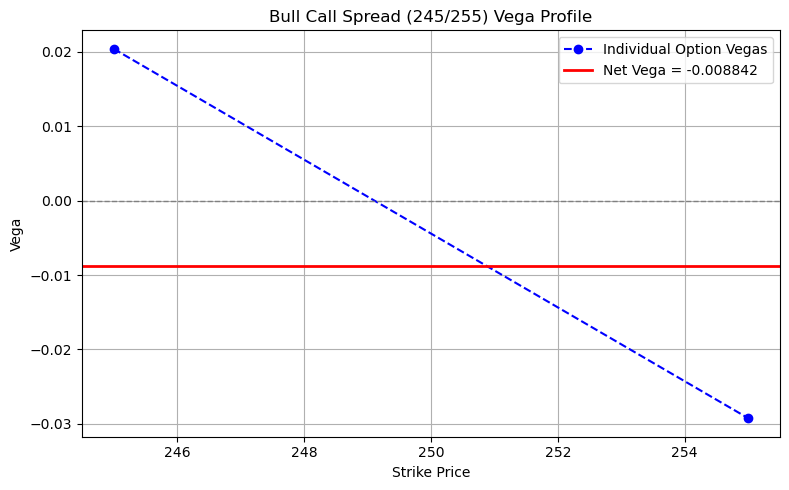

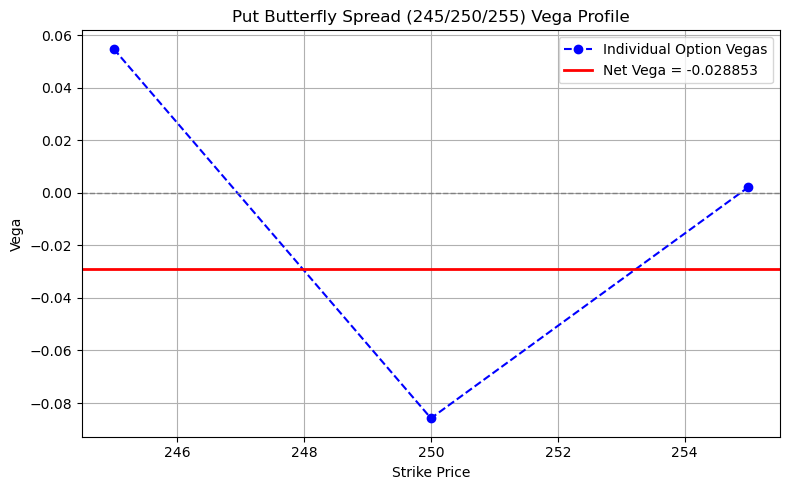

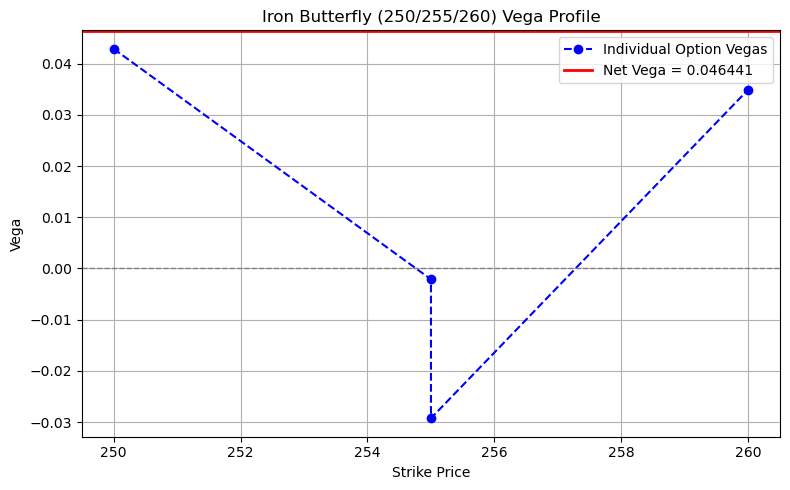

In [33]:
import matplotlib.pyplot as plt

def plot_vega_profile(spread_name, strikes, vegas, net_vega):
    plt.figure(figsize=(8, 5))
    plt.plot(strikes, vegas, marker='o', linestyle='--', color='blue', label='Individual Option Vegas')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(net_vega, color='red', linestyle='-', linewidth=2, label=f'Net Vega = {net_vega:.6f}')
    plt.title(f'{spread_name} Vega Profile')
    plt.xlabel('Strike Price')
    plt.ylabel('Vega')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example 1: Bull Call Spread (245/255)
bull_call_strikes = [245, 255]
bull_call_vegas = [calls[calls['strike'] == 245]['vega'].values[0], -calls[calls['strike'] == 255]['vega'].values[0]]
bull_call_net_vega = sum(bull_call_vegas)
plot_vega_profile("Bull Call Spread (245/255)", bull_call_strikes, bull_call_vegas, bull_call_net_vega)

# Example 2: Put Butterfly Spread (245/250/255)
put_butterfly_strikes = [245, 250, 255]
put_butterfly_vegas = [
    puts[puts['strike'] == 245]['vega'].values[0],
    -2 * puts[puts['strike'] == 250]['vega'].values[0],
    puts[puts['strike'] == 255]['vega'].values[0]
]
put_butterfly_net_vega = sum(put_butterfly_vegas)
plot_vega_profile("Put Butterfly Spread (245/250/255)", put_butterfly_strikes, put_butterfly_vegas, put_butterfly_net_vega)

# Example 3: Iron Butterfly (250/255/260)
# Call and put legs at 255 (short ATM), wings at 250 and 260 (long OTM)
iron_butterfly_strikes = [250, 255, 255, 260]
iron_butterfly_vegas = [
    puts[puts['strike'] == 250]['vega'].values[0],
    -puts[puts['strike'] == 255]['vega'].values[0],
    -calls[calls['strike'] == 255]['vega'].values[0],
    calls[calls['strike'] == 260]['vega'].values[0]
]
iron_butterfly_net_vega = sum(iron_butterfly_vegas)
plot_vega_profile("Iron Butterfly (250/255/260)", iron_butterfly_strikes, iron_butterfly_vegas, iron_butterfly_net_vega)